<a href="https://colab.research.google.com/github/mujahid345/BIke-sharing/blob/main/Bike_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u>  Seoul Bike Sharing Demand Prediction </u></b>

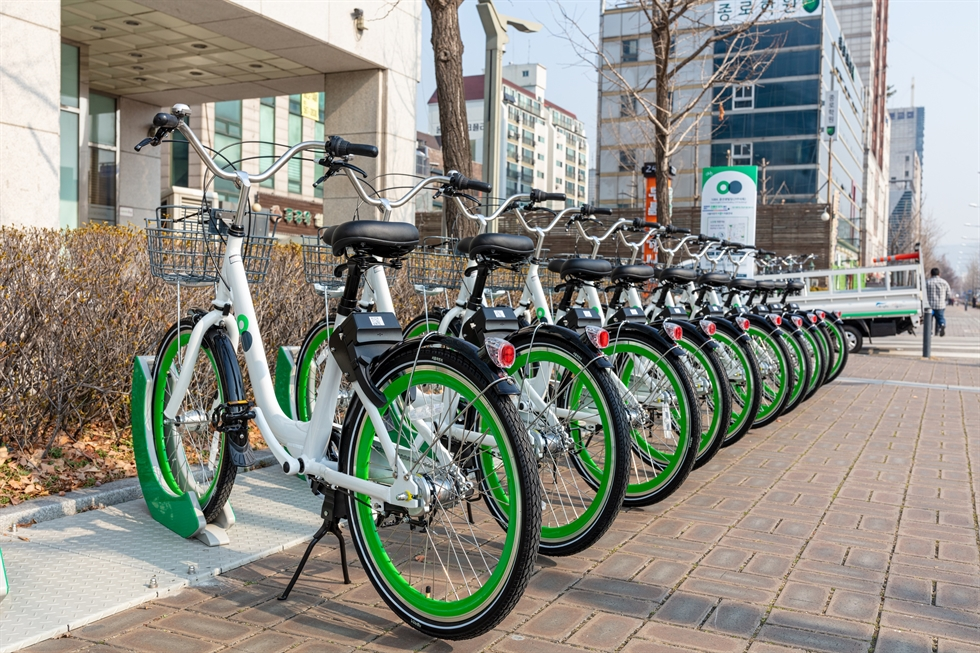

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes

## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [1]:
import pandas as pd
import numpy as np
from numpy import math
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.dpi'] = 100

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing Dataset with unicode_escape to avoid unicode Decode error while importing
df = pd.read_csv("/content/drive/MyDrive/Cohort Rishi/ML/SeoulBikeData.csv", encoding = 'unicode_escape')

In [4]:
df.head()  # ... inspecting the first 5 rows of data 

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [5]:
df.info()  #.. inspecting for any null values, data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [6]:
df.describe(include =['object'])  # .. Summary of non numeric datasets

Date Seasons     Holiday Functioning Day
count         8760    8760        8760            8760
unique         365       4           2               2
top     01/12/2017  Spring  No Holiday             Yes
freq            24    2208        8328            8465

In [7]:
df['Holiday'].value_counts()  # .... Checking for unique values of the Holiday Column

No Holiday    8328
Holiday        432
Name: Holiday, dtype: int64

In [8]:
len(df[df.duplicated()])  # ... Checking for duplicate values

0

In [9]:
# Creating variable wiht the name of categorical columns
categorical_variables = df.describe(include = 'object').columns
categorical_variables

Index(['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype='object')

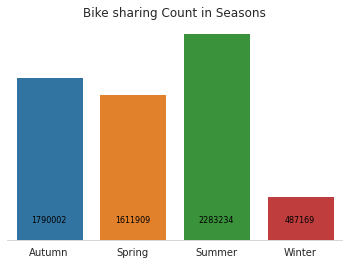

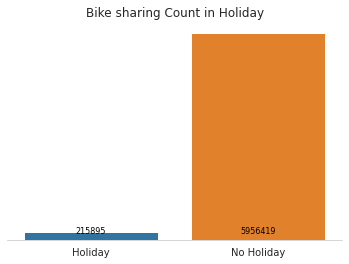

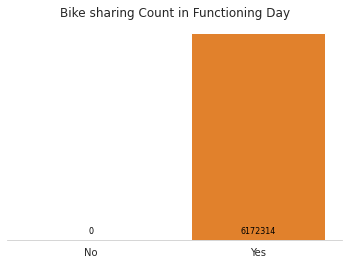

In [10]:
# Visualizing the Total number of rented bikes/ hr for against Seasons, Holidays  Functioning days
sns.set_style("whitegrid")
for i in categorical_variables[1:]:  
  fig = plt.figure(figsize = (6,4))
  ax = fig.gca()
  
  if df[i].nunique() < 5:      #.... ensuring categorical variable with not more than 5 unique values are considerd
    df_sample = df.groupby([i]).sum().reset_index().iloc[:,:2]
    sns.barplot(data = df_sample, x = df_sample[i], y = 'Rented Bike Count',ci = None, ax = ax)  # ... Creating the bargrahph 
    plt.title('Bike sharing Count in ' + i)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine(left = True)
    plt.yticks([])

    for j in range(len((df[i].unique()))):
      plt.text(x = j , y = 200000, s = df_sample.loc[j,'Rented Bike Count'],color='black', fontsize=8, horizontalalignment='center')




*   Most number of Bikes are rented in **Summer**, followed by **Autumn** and **Spring** and **Winter**

*   People prefer booking bikes on **Working days** more than the **Holidays**

*   All the bikes were rented on the **functioning day**

In [11]:
# Creating function to change the data format of the dataset
import datetime
def conv_dates_series(df, col, old_date_format, new_date_format):

    df[col] = pd.to_datetime(df[col], format=old_date_format).dt.strftime(new_date_format)
    
    return df

In [12]:
old_date_format= '%d/%m/%Y'   #.... current format of date not compatible for further EDA
new_date_format= "%Y-%m-%d"   #.... new format of date compatible for further EDA

conv_dates_series(df, 'Date', old_date_format, new_date_format)

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0     2017-12-01                254     0             -5.2           37   
1     2017-12-01                204     1             -5.5           38   
2     2017-12-01                173     2             -6.0           39   
3     2017-12-01                107     3             -6.2           40   
4     2017-12-01                 78     4             -6.0           36   
...          ...                ...   ...              ...          ...   
8755  2018-11-30               1003    19              4.2           34   
8756  2018-11-30                764    20              3.4           37   
8757  2018-11-30                694    21              2.6           39   
8758  2018-11-30                712    22              2.1           41   
8759  2018-11-30                584    23              1.9           43   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0                  2.2              2000                      -17.6   
1                  0.8              2000                      -17.6   
2                  1.0              2000                      -17.7   
3                  0.9              2000                      -17.6   
4                  2.3              2000                      -18.6   
...                ...               ...                        ...   
8755               2.6              1894                      -10.3   
8756               2.3              2000                       -9.9   
8757               0.3              1968                       -9.9   
8758               1.0              1859                       -9.8   
8759               1.3              1909                       -9.3   

      Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons  \
0                         0.0           0.0            0.0  Winter   
1                         0.0           0.0            0.0  Winter   
2                         0.0           0.0            0.0  Winter   
3                         0.0           0.0            0.0  Winter   
4                         0.0           0.0            0.0  Winter   
...                       ...           ...            ...     ...   
8755                      0.0           0.0            0.0  Autumn   
8756                      0.0           0.0            0.0  Autumn   
8757                      0.0           0.0            0.0  Autumn   
8758                      0.0           0.0            0.0  Autumn   
8759                      0.0           0.0            0.0  Autumn   

         Holiday Functioning Day  
0     No Holiday             Yes  
1     No Holiday             Yes  
2     No Holiday             Yes  
3     No Holiday             Yes  
4     No Holiday             Yes  
...          ...             ...  
8755  No Holiday             Yes  
8756  No Holiday             Yes  
8757  No Holiday             Yes  
8758  No Holiday             Yes  
8759  No Holiday             Yes  

[8760 rows x 14 columns]

In [13]:
# Extracting the Date, Month and Year of each Date from Datframe
df['month'] = None
df['year'] = None
df['day'] = None

for i in range(len(df.Date)):
  df['month'][i] = df['Date'][i][5:7]
  df['year'][i]  = df['Date'][i][:4]
  df['day'][i]  = df['Date'][i][8:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [14]:
df.head()  # ... inspecting the newly created columns

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  2017-12-01                254     0             -5.2           37   
1  2017-12-01                204     1             -5.5           38   
2  2017-12-01                173     2             -6.0           39   
3  2017-12-01                107     3             -6.2           40   
4  2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day month  year day  
0             Yes    12  2017  01  
1             Yes    12  2017  01  
2             Yes    12  2017  01  
3             Yes    12  2017  01  
4             Yes    12  2017  01

In [15]:
# Visualzing total Bikes rented in each month
df_by_month = df.groupby(['month']).sum().reset_index().iloc[:,:2]

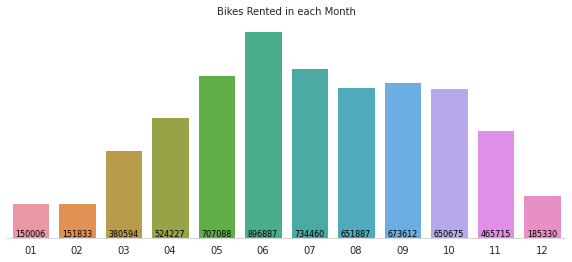

In [16]:
fig  = plt.figure(figsize = (10,4))
sns.barplot(data= df_by_month, x = 'month', y = 'Rented Bike Count')
plt.title ('Bikes Rented in each Month', fontsize  = 10)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
sns.despine(left = True)

for i in range(12):
  plt.text(x=i, y=8000, s=df_by_month.loc[i,'Rented Bike Count'], color='black', fontsize=8, horizontalalignment='center')



*   June is the most preferred Month for bike sharing with around **896K** bike shared.
*   July and May are the second best with total sharing of **734K** and **707K**.

*   Bike sharing was least in December and January with , **185K** and **150K**.



#**Analysing Numerical Features**

In [17]:
#creating list of numerical features
numeric_features = df.describe().columns

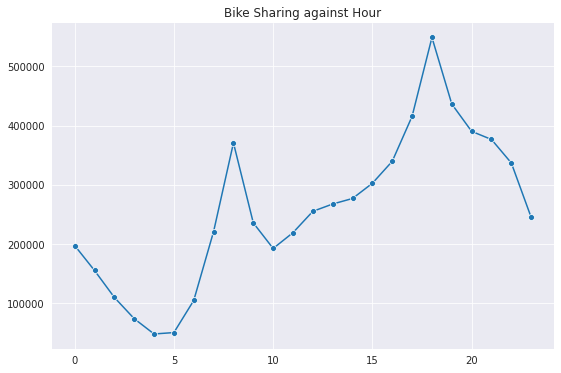

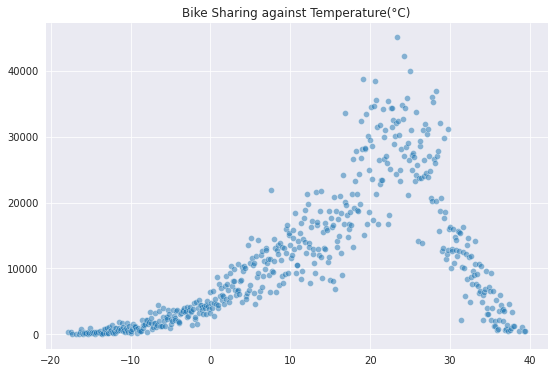

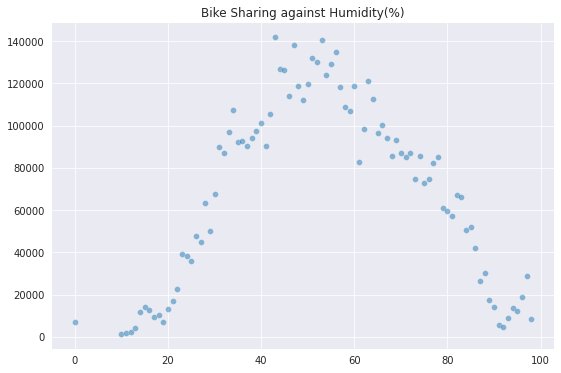

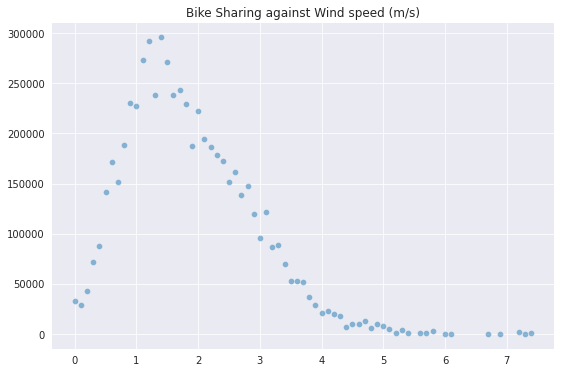

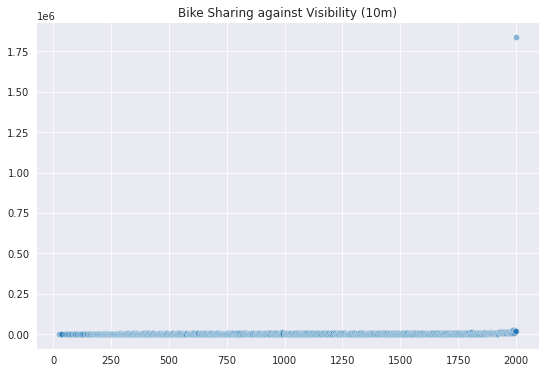

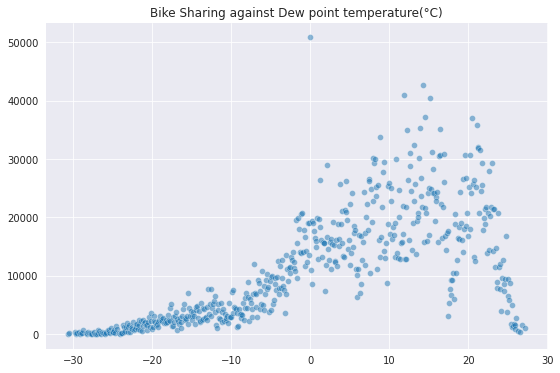

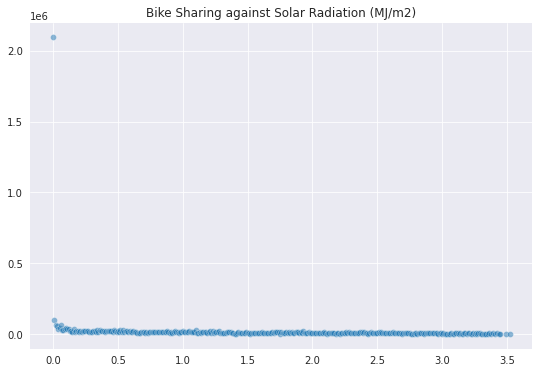

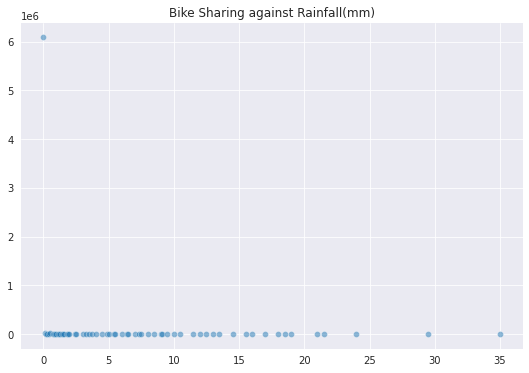

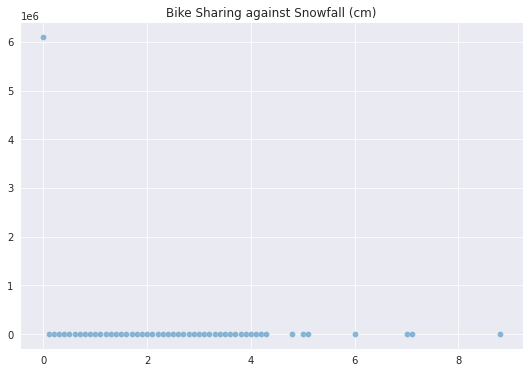

In [18]:
# Visualizing Bike rented count against Numerical Features
for i in (numeric_features[1:]):   #....exlcuding the bike rented count from for loop
  sns.set_style('darkgrid')        # ... setting up the background for the plot 
  fig = plt.figure(figsize = (9,6))
  ax = fig.gca()

  if df[i].nunique() < 25:       #... Creating line plot for varible with less than 25 unique values
    sns.lineplot(data = df.groupby([i]).sum().reset_index().iloc[:,:2], x = i ,  y = 'Rented Bike Count',marker = "o", ax = ax)
    
  else:                          #... Creating scatterplot for variable with more than 25 unique values
    sns.scatterplot(data = df.groupby([i]).sum().reset_index().iloc[:,:2], x = i ,  y = 'Rented Bike Count',ax =ax, alpha = 0.5)  
    
  plt.xlabel('')
  plt.ylabel('')
  ax.set_title(f'Bike Sharing against {i}')
  sns.despine(left = True, bottom =True)



*   Bike sharing is at its peak between **4pm- 6pm**

*   Bike shaing is least between **4am-6am.**

*   Most preferred temperature for bike renting is **20-30 Degree Celcius.**

*   Bike sharing is least when temperatur is **< 5 and >35 Degree Celcius.**

*   Humidity of **40%-60%** is most favourable for bike sharing.

*   Wind speed of **1m/s -2 m/s** is most favourable for bike sharing.

*   Bike sharing count is directly related to Visbility in the area.

*   Dew Point Temperature of **5-25 Degree Celcius** is most favourable for bike sharing.

*   **Optimum Solar Radiation, no rainfall and no snowfall** leads to higher bike renting in Seoul.

#**Visualizing co-relation between Count of Rented bike and numerical variables**

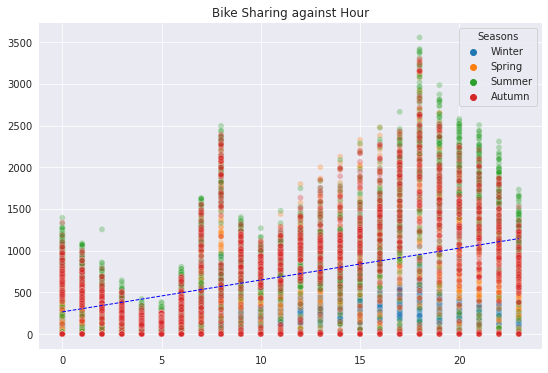

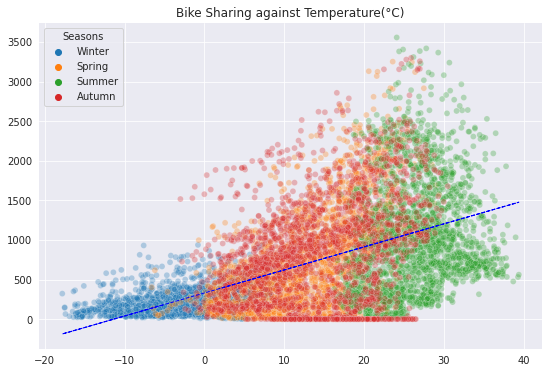

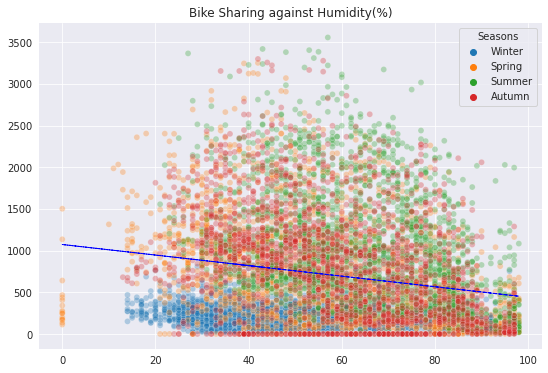

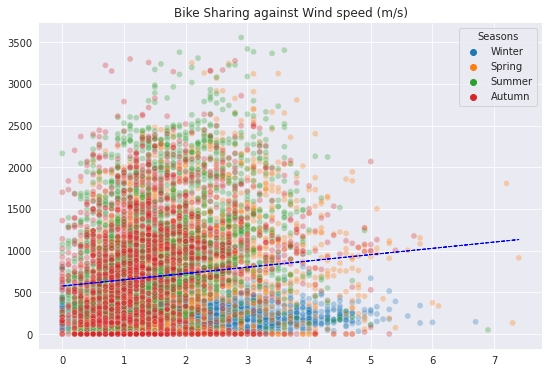

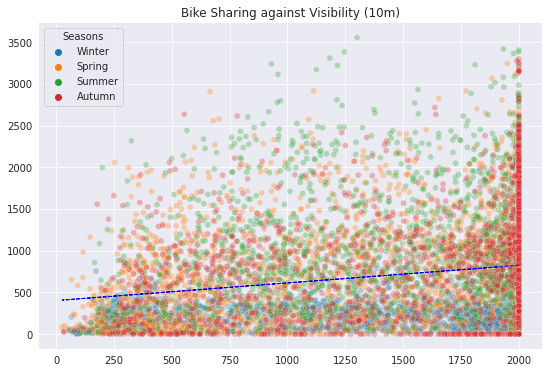

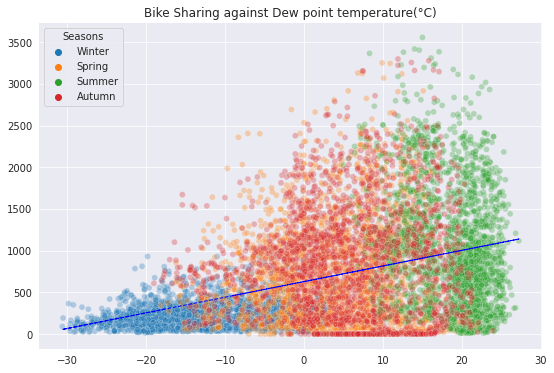

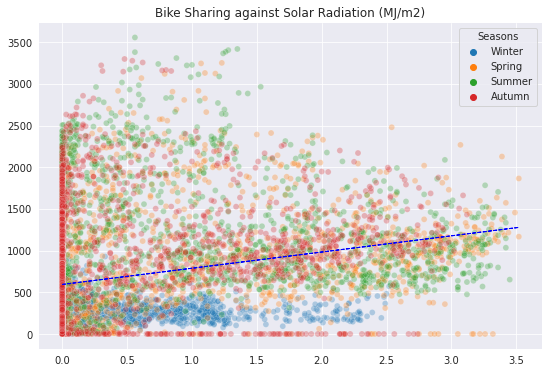

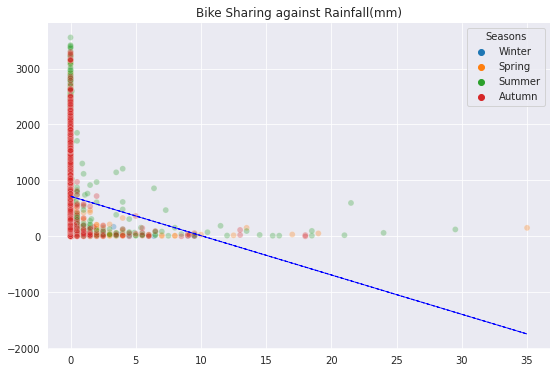

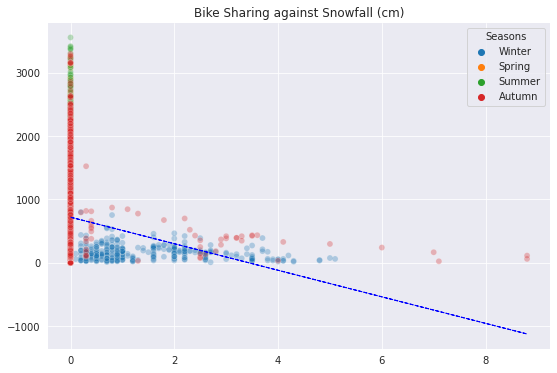

In [19]:
# Creating scatterplot to determine the co-relation
for i in (numeric_features[1:]):
  sns.set_style('darkgrid')
  fig = plt.figure(figsize = (9,6))
  ax = fig.gca()
  
  sns.scatterplot(data = df, x = i ,  y = 'Rented Bike Count' ,hue = 'Seasons', ax =ax, alpha = 0.3)  #... using Season as hue to see the distribution of count

  z = np.polyfit(df[i], df['Rented Bike Count'], 1)  # creating best fit line
  y_hat = np.poly1d(z)(df[i])
  plt.plot(df[i], y_hat, "b--", lw=1)
    
  plt.xlabel('')
  plt.ylabel('')
  ax.set_title(f'Bike Sharing against {i}')
  sns.despine(left = True, bottom =True)

*   Bike sharing count is positively co- related to Hour as the Hours Progress from 0 (12 am) to 20 (8pm) the bike sharing count increases.


*   Bike sharing is positively co-related to tempearature as the temperature approaches 30*C. 


*   Though one thing to notice the positive co-relation is applicable only because temp is Seoul rarely crosses 40 Degress

*   Humidity, Snowfall, Rainfall, are negatively co-related to Bike rent count.


*   Solar radiation and Dew Point temperatuer are slightly positively realted to Bike sharing count.

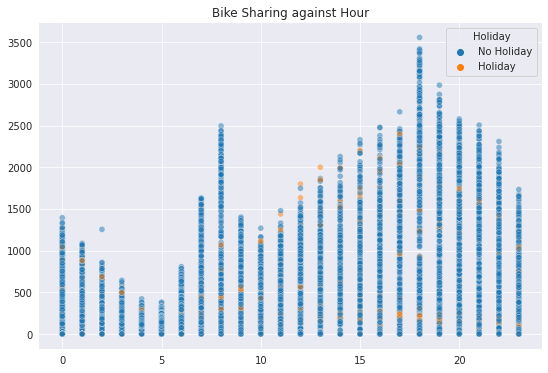

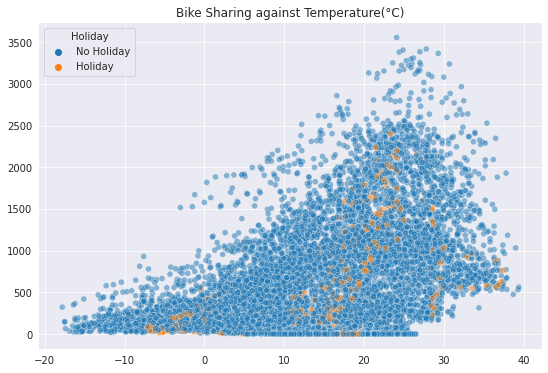

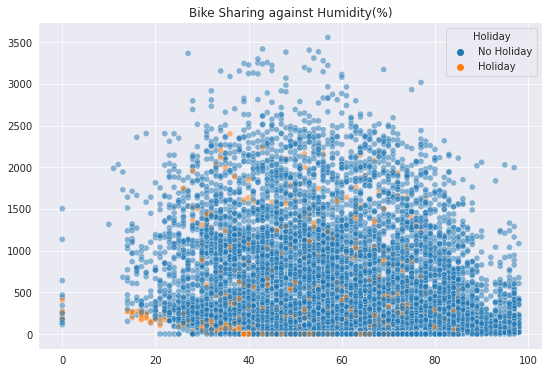

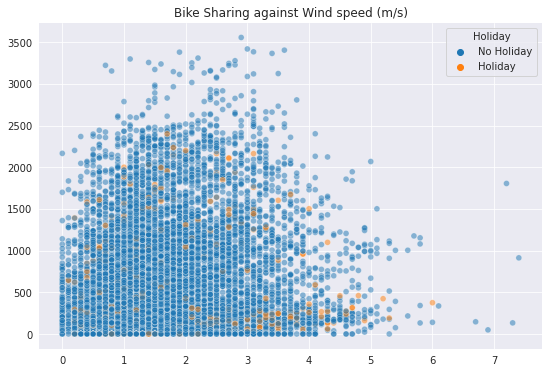

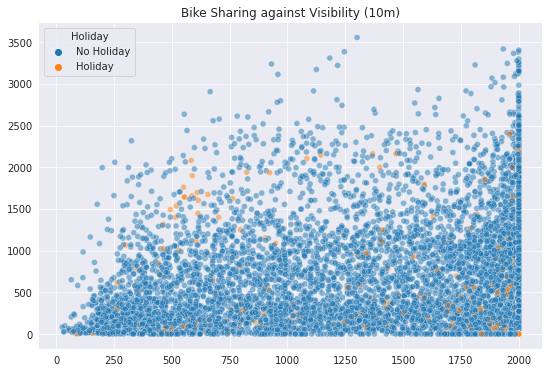

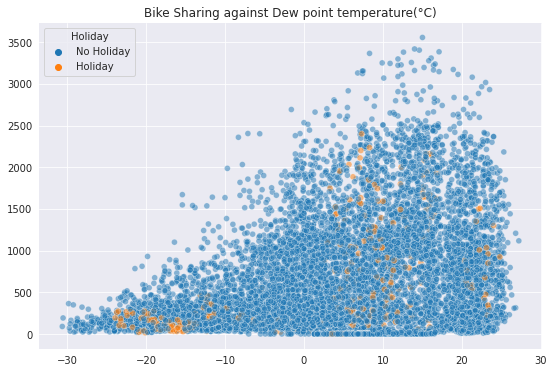

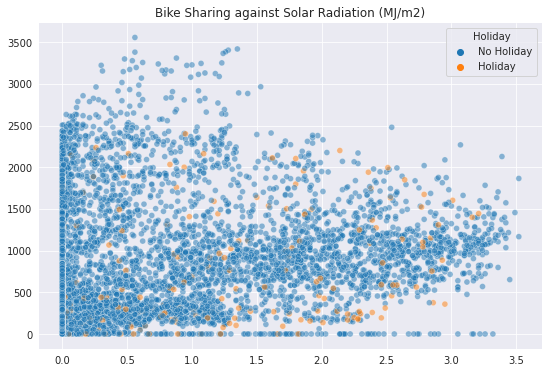

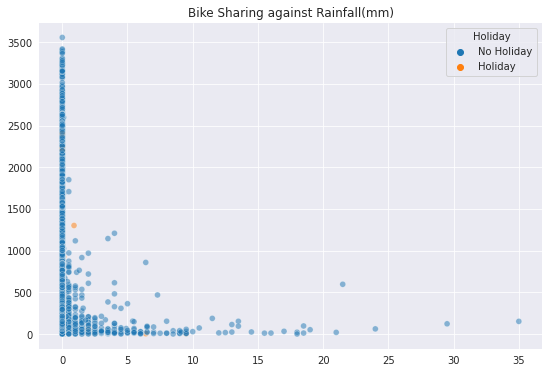

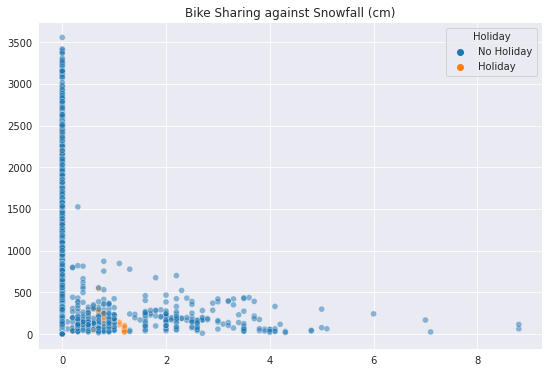

In [20]:
# Visualizing numerica variables again Holidays
for i in (numeric_features[1:]):
  sns.set_style('darkgrid')
  fig = plt.figure(figsize = (9,6))
  ax = fig.gca()
  sns.scatterplot(data = df, x = i ,  y = 'Rented Bike Count' ,hue = 'Holiday', ax =ax, alpha = 0.5)
  plt.xlabel('')
  plt.ylabel('')
  ax.set_title(f'Bike Sharing against {i}')
  sns.despine(left = True, bottom =True)



*   Bike sharing is minimal on Holidays irrespective of the temperature,humidity , solar radiation,snowfall compare to Working days


In [21]:
print(df.describe(include = ['object']).columns)
print(df.describe().columns)

Index(['Date', 'Seasons', 'Holiday', 'Functioning Day', 'month', 'year',
       'day'],
      dtype='object')
Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')


In [22]:
# Creating variaable to analayze the changes in diffrent climatic factors as per Season

climate = ['Hour','Temperature(°C)','Humidity(%)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)','Seasons']

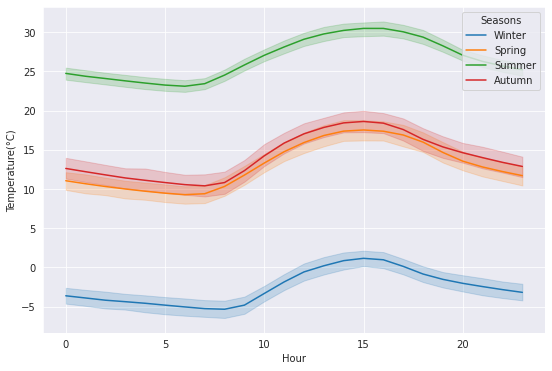

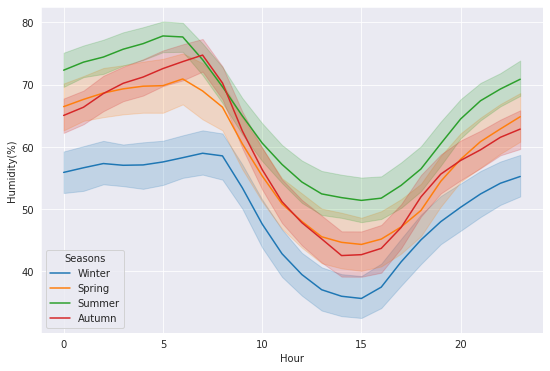

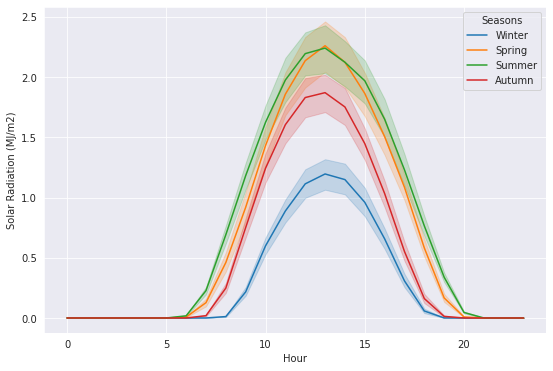

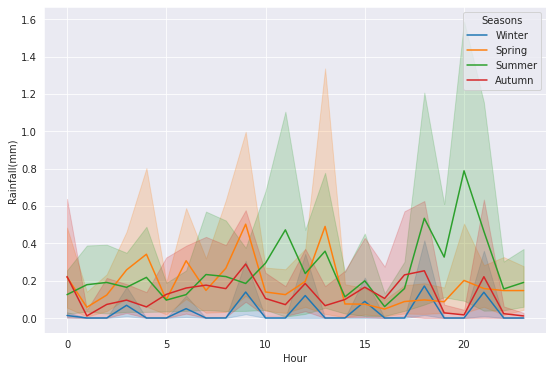

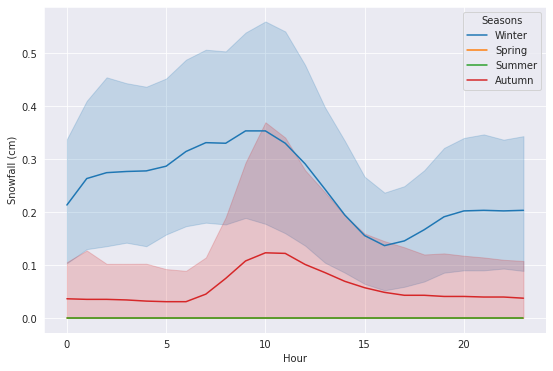

In [23]:
for i in climate[1:6]:
  fig = plt.figure(figsize = (9,6))
  ax = fig.gca()
  sns.lineplot(data = df, x = 'Hour',y = i , hue = 'Seasons')


*   Temperature in Summer vary between **24-31 Degrees**, in Autumn it varies between**10-18 Degrees**

*   Spring temperature are in between **9-16 Degrees** , for winter the range is **-5-3 Degress**

*   Humidity in Summer ranges from **52% - 77%**, in Autumn its **43% -74%**, for spring it varies from **41%-71%**, for winter the humidity is least from **36%-59%**

*   Solar Radiation is at its peak between **13:30pm -2:30 pm** in seoul across all the seasons  

*   **Summer and Spring** have the hightest recorded solar Radation of **2.25 MJ/m2**. Peak radiation in Autumn and Winter is aorung **1.8 MJ/m2** and **1.2 MJ/m2**.


*   Rainfall is most likely to occur in summer and Spring in Seoul.

*   Seoul experinces Heavy snowfall in winter followed by Autumn.








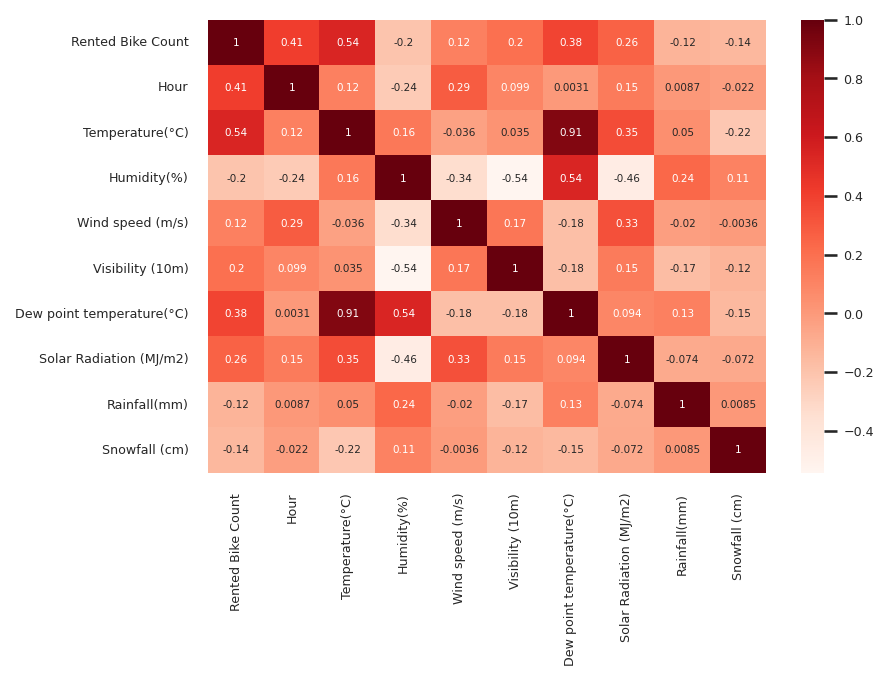

In [24]:
# Plotting Heat map for CO-relation between Feature and Labels
plt.rcParams['figure.dpi'] = 150
sns.set(font_scale= 0.55)
sns.heatmap(df.corr(), annot = True, cmap = 'Reds',annot_kws={'size': 5})



*   Heat map shows slightly postive relation of Rented bike count with **Hour, Temperature,Dew point Temperature, Solar Radiaton**

*   Bike sharing count is negatively co-related to **Humidity, Snowfall, Rainfall**

*   Temperature and Dew point temperature are positively co-related.


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# defining function to get the VIF of dataframe
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
# Converting the month, year and days columns to numeric type
df['month'] = pd.to_numeric(df['month'])
df['year'] = pd.to_numeric(df['year'])
df['day'] = pd.to_numeric(df['day'])

calc_vif(df[[i for i in df.describe().columns if i not in ['Rented Bike Count']]])

variables         VIF
0                        Hour    4.458880
1             Temperature(°C)  188.666573
2                 Humidity(%)  187.533688
3            Wind speed (m/s)    4.890096
4            Visibility (10m)   10.788995
5   Dew point temperature(°C)  126.954261
6     Solar Radiation (MJ/m2)    2.904971
7                Rainfall(mm)    1.103386
8               Snowfall (cm)    1.155412
9                       month    5.108772
10                       year  407.025112
11                        day    4.379818

 
*   From above Dataframe Year column has the highest multicolinearity.

*   we wil have to drop year column from Regression analaysis to ensure the accurate prediction from Linear regression model






In [27]:
calc_vif(df[[i for i in df.describe().columns if i not in ['Rented Bike Count','year']]])  # ... dropping year colum from Dataset

variables        VIF
0                        Hour   4.425960
1             Temperature(°C)  38.389623
2                 Humidity(%)   8.344305
3            Wind speed (m/s)   4.879565
4            Visibility (10m)   9.481423
5   Dew point temperature(°C)  19.815223
6     Solar Radiation (MJ/m2)   2.900819
7                Rainfall(mm)   1.082134
8               Snowfall (cm)   1.144168
9                       month   5.096115
10                        day   4.292003